In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

# 
import covasim as cv

# Import EMA Workbench modules 
from ema_workbench import (ReplicatorModel, RealParameter, BooleanParameter, IntegerParameter, Constant, TimeSeriesOutcome, perform_experiments, save_results, ema_logging)

# Initialize logger to keep track of experiments run
ema_logging.log_to_stderr(ema_logging.INFO)

Covasim 3.0.3 (2021-05-17) — © 2021 by IDM


/opt/anaconda3/envs/sa-with-ema/lib/python3.8/site-packages/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


<Logger EMA (DEBUG)>

## 1. Load the model

In [2]:
pars = {'pop_size' : 100,
        'pop_infected' : 10,
        'n_days' : 30,
        'rescale_threshold' : 0.01,
        'verbose' : 0}

In [3]:
# 
def covasim_model(pop_size, pop_infected, n_days, rescale_threshold, verbose):
    pars = {'pop_size' : pop_size,
            'pop_infected' : pop_infected,
            'n_days' : n_days,
            'rescale_threshold' : rescale_threshold,
            'verbose' : verbose}
    sim = cv.Sim(pars=pars)
    sim.initialize()
    sim.run()
    outcomes = sim.results

    date = outcomes['date']
    cum_infections = outcomes['cum_infections'].values
    cum_recoveries = outcomes['cum_recoveries'].values
    cum_deaths = outcomes['cum_deaths'].values

    return {'cum_infections' : cum_infections,
            'cum_recoveries' : cum_recoveries,
            'cum_deaths' : cum_deaths}

In [4]:
covasim_model(pop_size=100, 
              pop_infected=10, 
              n_days=30, 
              rescale_threshold=0.01, 
              verbose=0)

{'cum_infections': array([10., 10., 10., 11., 11., 14., 14., 15., 16., 20., 22., 24., 26.,
        26., 28., 30., 33., 35., 35., 35., 37., 38., 40., 42., 44., 44.,
        48., 50., 52., 53., 56.]),
 'cum_recoveries': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  3.,  5.,  5.,
         5.,  6.,  9., 10., 11., 13., 13., 13., 16., 17., 21., 23., 23.,
        24., 27., 31., 31., 33.]),
 'cum_deaths': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

## 2. Design experiments

In [5]:
# Instantiate and pass the model 
model = ReplicatorModel('CovasimModel', function=covasim_model)

In [29]:
# Define model parameters and their ranges to be sampled
model.uncertainties = [IntegerParameter("pop_size", 500, 1000),
                       IntegerParameter("pop_infected", 1, 10),
                       RealParameter("rescale_threshold", 0.01, 0.1)]

# Define model parameters that will remain constant
model.constants = [Constant('n_days', 30),
                   Constant('verbose', 0)]

# Define model outcomes
model.outcomes = [TimeSeriesOutcome('cum_infections'),
                  TimeSeriesOutcome('cum_recoveries'),
                  TimeSeriesOutcome('cum_deaths')]

# Define the number of replications
model.replications = 5

## 3. Run the model

In [30]:
# Run experiments with the aforementioned parameters and outputs
results = perform_experiments(models=model, scenarios=100)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [31]:
# Get the results
experiments, outcomes = results

In [32]:
experiments.head()

,pop_infected,pop_size,rescale_threshold,scenario,policy,model
0,6.0,595.0,0.017813,100,None,CovasimModel
1,4.0,771.0,0.047527,101,None,CovasimModel
2,8.0,646.0,0.064557,102,None,CovasimModel
3,9.0,862.0,0.038036,103,None,CovasimModel
4,1.0,689.0,0.050285,104,None,CovasimModel


In [33]:
outcomes.keys()

dict_keys(['cum_infections', 'cum_recoveries', 'cum_deaths'])

Often it is a good idea to save the results of a lengthy run and open up it next day 🥱. Great that EMA Workbench has such a feature.

### Epic save

<center><img src="img/save.jpg" width=200 height=260/><center>

In [34]:
from ema_workbench.util.utilities import save_results, load_results
import os

In [35]:
# Create a directory to store the results
directory = 'results/covasim_on_ema'
if not os.path.exists(directory):
    os.makedirs(directory)

In [36]:
# Save the results
save_results(results, directory + '/results.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/sophieayling/Documents/GitHub/SSF2021/results/covasim_on_ema/results.tar.gz


In [37]:
# Load the results
results = load_results(directory + '/results.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/sophieayling/Documents/GitHub/SSF2021/results/covasim_on_ema/results.tar.gz


In [38]:
experiments, outcomes = results

In [39]:
outcomes['cum_infections'].shape

(100, 5, 31)

### A bit of preprocessing

Before we proceed further, we have to do a bit of preprocessing. Let's take a closer look at the outcomes. We have 4 outcomes, 1400 scenarios, 10 replications and we run the model for 30 steps. This is what you see down below:

In [40]:
print(random.choice(list(outcomes)))
outcomes[random.choice(list(outcomes))].shape

cum_infections


(100, 5, 31)

To simplify our life 😅, let's take a mean over all replications that we had. 

In [41]:
mean_outcomes = {key:np.mean(outcomes[key],axis=1) for key in outcomes.keys()}
mean_results = (experiments.copy(), mean_outcomes)

In [42]:
# Now the shape of this array doesn't have 10 in it  
mean_outcomes[random.choice(list(outcomes))].shape

(100, 31)

### Visuals!

In [43]:
from ema_workbench.analysis.plotting import lines

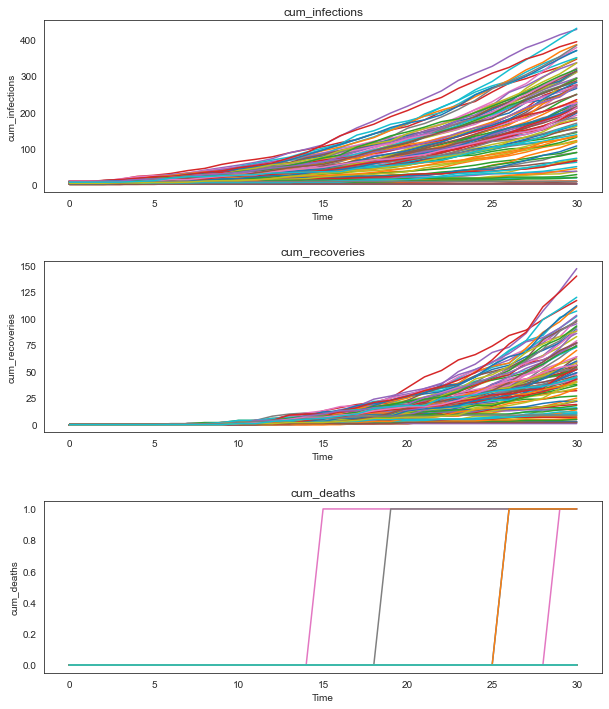

In [44]:
plt.rcParams['figure.figsize'] = [10, 12]
figure = lines(experiments, mean_outcomes)

## 4. Do sensitivity analysis

Finally, we're here 🧙. EMA Workbench and SALib have different methods available for sampling and SA. Here we're going to use Variance-based Sensitivity Analysis also known as Sobol (by the surname of its author). Take a look at other options available there. As usual the most complex task here is to find out whether your model fits the method. As Confucius said "*If you found a method that fits your problem within an hour, you're either a method developer or most probably bamboozled yourself.*" 
For now, let's imagine that we found the right method and it is Sobol.

The *tech* part here is relatively straightforward:

1. Specify a *problem*, or simply say what model parameters did you sample,
2. Select an *outcome* of interest, yes, we have to analyze the impact outcome by outcome,
3. Run the analysis.  

In [23]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from src.plot import plot_sobol_indices
sns.set_style('white')

In [24]:
# Specify the problem
problem = get_SALib_problem(model.uncertainties)

In [27]:
# Select and normalize an outcome
normalized_resistant = (mean_outcomes['cum_recoveries'][:,-1] / experiments['pop_infected']).to_numpy()

# Not sure why we are using -1 here 

In [28]:
# Perform Sobol SA
Si = sobol.analyze(problem=problem, Y=normalized_resistant,
                   calc_second_order=True, print_to_console=False)

# Get scores by type 
Si_filter = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}

# Create a DataFrame out of them
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

# Get indices and error bars
indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

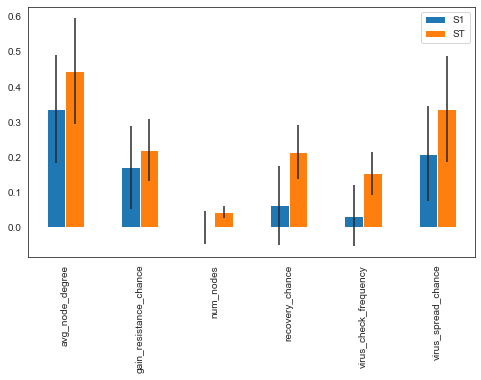

In [25]:
# Plot the results as a barplot
fig, ax = plt.subplots(1)
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

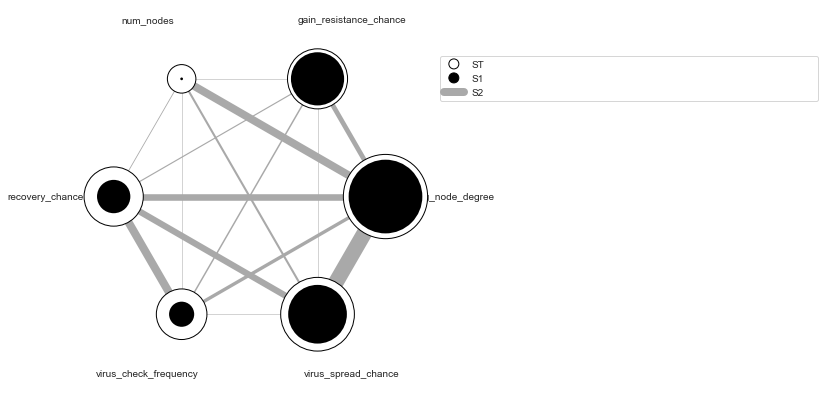

In [26]:
# Even a nicer plot
fig = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)